<a href="https://colab.research.google.com/github/bebechien/gemma/blob/main/How_to_Fine_tuning_Gemma_Japanese_Haiku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# How to Fine-tuning Gemma: Best Practices

## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.


### Gemma setup on Kaggle
To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run the Gemma 2B model.
* Generate and configure a Kaggle username and API key.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.

### Set environemnt variables

Set environement variables for ```KAGGLE_USERNAME``` and ```KAGGLE_KEY```.

In [1]:
import os
from google.colab import userdata, drive

# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate for your system.
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")

# Mounting gDrive for to store artifacts
#drive.mount("/content/drive")

Mounted at /content/drive


### Install dependencies

Install Keras and KerasNLP

In [2]:
!pip install -q -U keras-nlp datasets
!pip install -q -U keras

# Set the backbend before importing Keras
os.environ["KERAS_BACKEND"] = "jax"
# Avoid memory fragmentation on JAX backend.
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "1.00"

import keras_nlp
import keras

# Run at half precision.
#keras.config.set_floatx("bfloat16")

# Training Configurations
token_limit = 128
num_data_limit = 400
lora_name = "haiku"
lora_rank = 4
lr_value = 1e-4
train_epoch = 10
model_id = "gemma2_2b_en"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.1/548.1 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.5 MB/

## Load Model

In [3]:
import keras
import keras_nlp

import time

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
gemma_lm.summary()

tick_start = 0

def tick():
    global tick_start
    tick_start = time.time()

def tock():
    print(f"TOTAL TIME ELAPSED: {time.time() - tick_start:.2f}s")

def text_gen(prompt):
    tick()
    output = gemma_lm.generate(prompt, max_length=token_limit)
    print("\nGemma output:")
    print(output)
    tock()

# inference before fine-tuning
text_gen("何となく")
text_gen("こんにちは")


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                              │                      Vocab size: 256,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,614,341,888 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,614,341,888 (9.74 GB)

 Trainable params: 2,614,341,888 (9.74 GB)

 Non-trainable params: 0 (0.00 B)


Gemma output:
何となく、このブログのタイトルに「<strong>お笑い芸人</strong>」という言葉が似合う気がして、ついこの前、<strong>お笑い芸人</strong>の<strong>「お笑い芸人」</strong>というタイトルでブログを立ち上げました。

しかし、<strong>お笑い芸人</strong>の<strong>「お笑い芸人」</strong>というタイトルでブログを立ち上げたのは、<strong>お笑い芸人</strong>の<strong>「お笑い芸人」</strong>というタイトルでブログを立ち上げたからではありません。

<strong>お笑い芸人</strong>の<strong>「お笑い芸人」</strong>というタイトルでブログを立ち上げたのは
TOTAL TIME ELAPSED: 22.19s

Gemma output:
こんにちは。

今日は、

<strong>「</strong><strong>おうちでできる！</strong><strong>」</strong>

<strong>「</strong><strong>おうちでできる！</strong><strong>」</strong>

<strong>「</strong><strong>おうちでできる！</strong><strong>」</strong>

<strong>「</strong><strong>おうちでできる！</strong><strong>」</strong>

<strong>「</strong><strong>おうちでできる！</strong><strong>」</strong>

<strong>「</strong><strong>おうちでできる！</strong><strong>」</strong>

<strong>「</strong><strong>おうちでできる！</strong><strong>」</strong>

<strong>「</strong><strong>おうちでできる！</strong><strong>」</strong>

<strong>「</strong><strong>おうちでできる！
TOTAL TIME ELAPSED: 6.49s


## Tokenizer designed with multilingual in mind

In [5]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)
import jax

def detoken(tokens):
  print(tokens)
  for x in tokens:
    word = tokenizer.detokenize(jax.numpy.array([x]))
    print(f"{x:6} -> {word}")

detoken(tokenizer("こんにちは。初めまして。今日は本当にいい天気ですね。"))

[ 32789 235362 147035  60914 235362  40574  35752  10598 106577  14088
 235362]
 32789 -> こんにちは
235362 -> 。
147035 -> 初め
 60914 -> まして
235362 -> 。
 40574 -> 今日は
 35752 -> 本当に
 10598 -> いい
106577 -> 天気
 14088 -> ですね
235362 -> 。


## Load Dataset

In [ ]:
tokenizer = keras_nlp.models.GemmaTokenizer.from_preset(model_id)

from datasets import load_dataset
ds = load_dataset(
    "p1atdev/modern_haiku",
    split="train",
    trust_remote_code=True
).shuffle(1234)
print(ds)
data = ds.with_format("np", columns="haiku", output_all_columns=False)

train = []

for x in data:
  length = len(tokenizer(x['haiku']))
  # skip data if the token length is longer than our limit
  if length < token_limit:
    train.append(x['haiku'])
    if(len(train)>=num_data_limit):
      break

print(len(train))
print(train[0])
print(train[1])
print(train[2])

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'haiku', 'author', 'foreword', 'source', 'comment', 'reviewer', 'note', 'season', 'kigo'],
    num_rows: 37158
})
400
神々のあくびが桜を枯らすのか
火種消すように萱草摘み始め
舌出して浅蜊本音は明かさずに


## LoRA Fine-tuning

In [ ]:
# Enable LoRA for the model and set the LoRA rank to 4.
gemma_lm.backbone.enable_lora(rank=lora_rank)
gemma_lm.summary()

# Limit the input sequence length (to control memory usage).
gemma_lm.preprocessor.sequence_length = token_limit
# Use AdamW (a common optimizer for transformer models).
optimizer = keras.optimizers.AdamW(
    learning_rate=lr_value,
    weight_decay=0.01,
)
# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

gemma_lm.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    weighted_metrics=[keras.metrics.SparseCategoricalAccuracy()],
)


Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2304)        │   2,617,270,528 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     589,824,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,617,270,528 (9.75 GB)

 Trainable params: 2,928,640 (11.17 MB)

 Non-trainable params: 2,614,341,888 (9.74 GB)

Note that enabling LoRA reduces the number of trainable parameters significantly.

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.6512 - sparse_categorical_accuracy: 0.1245   
Gemma output:
何となくの空に
TOTAL TIME ELAPSED: 17.15s

Gemma output:
こんにちは、おやじのひろしです。

今日は、おやじのひろしが、おやじのひろしを、ひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろしをひろしにひろし
TOTAL TIME ELAPSED: 8.38s
200/200 ━━━━━━━━━━━━━━━━━━━━ 289s 1s/step - loss: 0.6510 - sparse_categorical_accuracy: 0.1247
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - loss: 0.5284 - sparse_categorical_accuracy: 0.2024
Gemma output:
何となくの夏にふらふら
TOTAL TIME ELAPSED: 0.71s

Gemma output:
こんにちは、おやじのひかり
TOTAL TIME ELAPSED: 0.69s
200/200 ━━━━━━━━━━━━━━━━━━━━ 204s 918ms/step - loss: 0.5284 - sparse_categorical_accuracy: 0.2024
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.4920 - sparse_categorical_accuracy: 0.2156   
Gemma output:
何となくの空に雲の影あり
TOTAL TIME ELAPSED: 0.69s

Gemma output:
こんにちは、おやじのひかり
TOTAL TIME ELAPSED: 0.69s
200/200 ━

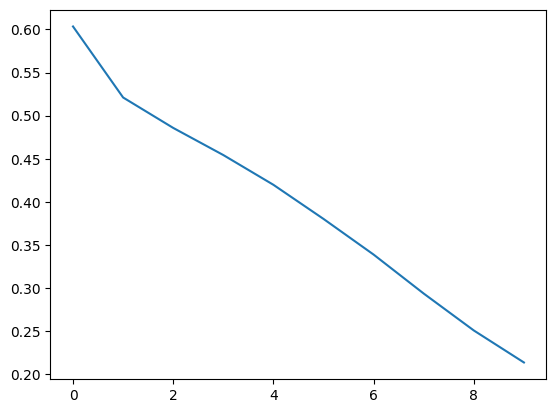

In [ ]:
class CustomCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #model_name = f"/content/drive/MyDrive/{lora_name}_{lora_rank}_epoch{epoch+1}.lora.h5"
    #gemma_lm.backbone.save_lora_weights(model_name)

    # Evaluate
    text_gen("何となく")
    text_gen("こんにちは")

history = gemma_lm.fit(train, epochs=train_epoch, batch_size=2, callbacks=[CustomCallback()])

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.show()

## Load LoRA

In [ ]:
#gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(model_id)
# Use the same LoRA rank that you trained
#gemma_lm.backbone.enable_lora(rank=4)

# Load pre-trained LoRA weights
#gemma_lm.backbone.load_lora_weights(f"/content/drive/MyDrive/{lora_name}_{lora_rank}_epoch{train_epoch}.lora.h5")

## Try a different sampler

The top-K algorithm randomly picks the next token from the tokens of top K probability.

In [ ]:
gemma_lm.compile(sampler="top_k")
text_gen("何となく")
text_gen("何となく")
text_gen("何となく")
text_gen("何となく")
text_gen("何となく")


Gemma output:
何となく春分なのか昼
TOTAL TIME ELAPSED: 16.69s

Gemma output:
何となく冬木枯らしたての枕
TOTAL TIME ELAPSED: 0.78s

Gemma output:
何となく春雨の音にまみれなり
TOTAL TIME ELAPSED: 0.80s

Gemma output:
何となくあBeginInit
TOTAL TIME ELAPSED: 0.40s

Gemma output:
何となく夏が過ぎゆく町 ishikuro no nagara yukina natsu ga uzurakume
TOTAL TIME ELAPSED: 1.60s


Try a slight different prompts

In [ ]:
text_gen("春雨")
text_gen("夏の")
text_gen("秋風")
text_gen("冬空")


Gemma output:
春雨やぶるも破れぬは稻 stalks
TOTAL TIME ELAPSED: 0.91s

Gemma output:
夏の草は腰を据えて待つ
TOTAL TIME ELAPSED: 0.72s

Gemma output:
秋風やとらをとらえて舞う
TOTAL TIME ELAPSED: 0.78s

Gemma output:
冬空に雁を落とす理由なし
TOTAL TIME ELAPSED: 0.72s
